# Overview Notes

In this chapter, we are going to further expand on the following topics:

**Regression:**
* Simple linear regression
* Multi regression
* Regularized regression
* Lasso regularization
* Ridge regularization
* ElasticNet regularization

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Generated-Datasets" data-toc-modified-id="Generated-Datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generated Datasets</a></span></li><li><span><a href="#Boston-Dataset" data-toc-modified-id="Boston-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Boston Dataset</a></span></li><li><span><a href="#Simple-Multi-Regression" data-toc-modified-id="Simple-Multi-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simple Multi Regression</a></span></li><li><span><a href="#Regularization" data-toc-modified-id="Regularization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Regularization</a></span><ul class="toc-item"><li><span><a href="#Lasso-Regularlization" data-toc-modified-id="Lasso-Regularlization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Lasso Regularlization</a></span></li><li><span><a href="#Ridge-Regularization" data-toc-modified-id="Ridge-Regularization-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ridge Regularization</a></span></li><li><span><a href="#ElasticNet-Regularization" data-toc-modified-id="ElasticNet-Regularization-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>ElasticNet Regularization</a></span></li></ul></li></ul></div>

# Regression with TensorFlow <a class="tocSkip">

In [1]:
import tensorflow as tf
print('TensorFlow:{}'.format(tf.__version__))
tf.set_random_seed(123)
tf.reset_default_graph()

TensorFlow:1.15.5


In [2]:
import numpy as np
print('NumPy:{}'.format(np.__version__))
np.random.seed(123)

NumPy:1.18.5


In [3]:
# ^ Note we set TF and Numpy seeds above.

In [4]:
import matplotlib.pyplot as plt

# Note: this magic call may no longer be needed in recent versions of jupyter:
%matplotlib inline

In [5]:
import sklearn as sk
print('Scikit Learn:{}'.format(sk.__version__))

Scikit Learn:0.24.2


In [6]:
import sklearn.model_selection
import sklearn.datasets
import sklearn.preprocessing

# Generated Datasets

In [7]:
X, y = sklearn.datasets.make_regression(
    n_samples=200, 
    n_features=1, 
    n_informative=1, 
    n_targets=1, 
    noise=20.0
)

In [8]:
print("X.shape:", X.shape)
print("y.shape:", y.shape)
print("X[0]", X[0])
print("y[0]", y[0])

X.shape: (200, 1)
y.shape: (200,)
X[0] [-1.72766949]
y[0] -23.509583948098456


In [9]:
# To match shapes as TF would expect.
if (y.ndim == 1):
    y = y.reshape(-1, 1)
print("y.shape:", y.shape)
print("y[0]", y[0])

y.shape: (200, 1)
y[0] [-23.50958395]


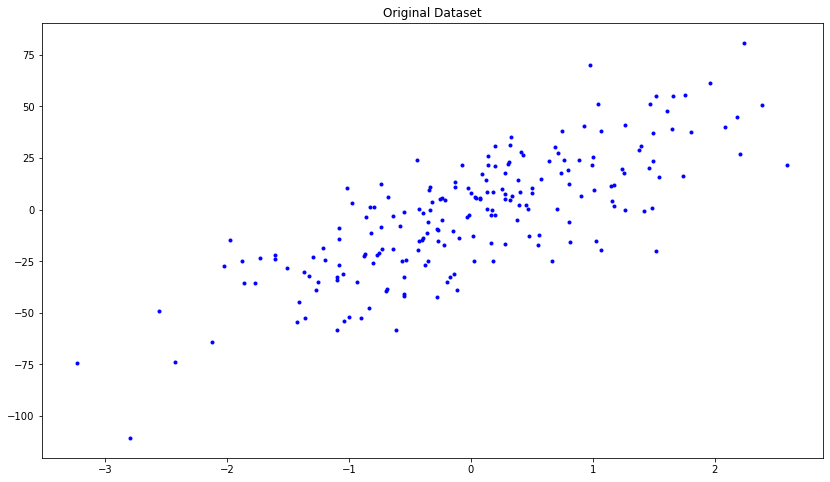

In [10]:
plt.figure(figsize=(14,8))
plt.plot(X, y, 'b.')
plt.title('Original Dataset')
plt.show()

In [11]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, 
    y, 
    test_size=.4, 
    random_state=123
)
print("X_train.shape", X_train.shape, "y_test.shape", y_test.shape)

X_train.shape (120, 1) y_test.shape (80, 1)


# (Univariate) Linear Regression

#### To build and train a regression model in TensorFlow, the following steps are taken in general:
1. Defining the **inputs**, **parameters**, and *other variables*.
2. Defining the **model**.
3. Defining the **loss function**.
4. Defining the **optimizer** function.
5. Training the model for a number of iterations known as epochs.

#### 1. Defining the **inputs**, **parameters**, and *other variables*...

In [14]:
num_output_features = y_train.shape[1]
num_input_features = X_train.shape[1]
print("num_output_features:", num_output_features, "\tnum_input_features:", num_input_features)

num_output_features: 1 	num_input_features: 1


In [16]:
# Define the data `placeholder`s:
x_tensor = tf.placeholder(
    dtype=tf.float32, 
    shape=[None, num_input_features],  # NOTE: Variable rows = None 
    name='x'
)
y_tensor = tf.placeholder(
    dtype=tf.float32, 
    shape=[None, num_output_features], 
    name='y'
)
print("x_tensor:", x_tensor)
print("y_tensor:", y_tensor)

x_tensor: Tensor("x:0", shape=(?, 1), dtype=float32)
y_tensor: Tensor("y:0", shape=(?, 1), dtype=float32)


In [17]:
# Define parameters as `Variable`s:
w = tf.Variable(
    tf.zeros([num_input_features, num_output_features]), 
    dtype=tf.float32, 
    name='w'  # Note the setting of `name`.
)
b = tf.Variable(
    tf.zeros([num_output_features]), 
    dtype=tf.float32, 
    name='b'  # Note the setting of `name`.
)
print("w:", w)
print("b:", b)

w: <tf.Variable 'w:0' shape=(1, 1) dtype=float32_ref>
b: <tf.Variable 'b:0' shape=(1,) dtype=float32_ref>


#### 2. Defining the **model**.

In [19]:
# `model` is ultimately always just some kind of function. Here, it's the linear regression. 
model = tf.matmul(x_tensor, w) + b  # Note the use of `tf.matmul()`, not just *
print("model", model)

model Tensor("add_1:0", shape=(?, 1), dtype=float32)


#### 3. Defining the **loss function**.

* Use **MSE**.
* The difference in the actual and estimated value of $y$ is known as **residual**. The loss function calculates the *mean of squared residuals*.


* `model - y_tensor` calculates the residuals
* `tf.square(model - y_tensor)` calculates the squares of each residual
* `tf.reduce_mean( ... )` finally calculates the mean of squares calculated in the preceding step

In [20]:
# Loss here is of course just simple MSE.
loss = tf.reduce_mean(tf.square(model - y_tensor))
print("loss:", loss)

loss: Tensor("Mean:0", shape=(), dtype=float32)


### Evaluation metrics.
1. MSE - same as loss here.
2. $R^2$

In [21]:
# MSE
mse =  tf.reduce_mean(tf.square(model - y_tensor))

# R^2
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))  # target <--> target_mean
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))  # model <--> target [exactly the same same as MSE]
rs = 1 - tf.div(unexplained_error, total_error)  # 1 - (ratio of the above two)

print("MSE:", mse)
print("R^2:", rs)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
MSE: Tensor("Mean_1:0", shape=(), dtype=float32)
R^2: Tensor("sub_4:0", shape=(), dtype=float32)


#### 4. Defining the **optimizer** function.

In [25]:
learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  # Note the explicit call to `<opt>.minimize(loss)`!

print("type(optimizer)", type(optimizer))  # Note that optimizer is in fact an op (tensorflow.python.framework.ops.Operation)
print("optimizer:", optimizer)

type(optimizer) <class 'tensorflow.python.framework.ops.Operation'>
optimizer: name: "GradientDescent_2"
op: "NoOp"
input: "^GradientDescent_2/update_w/ApplyGradientDescent"
input: "^GradientDescent_2/update_b/ApplyGradientDescent"



#### 5. Training the model for a number of iterations known as epochs.

In [23]:
# Define "global" variables before training.

num_epochs = 1500

w_hat, b_hat = 0, 0  # To collect the estimated w and b parameters.

# To collect the: 
#   - total error value on the *training* dataset, 
#   - the mse and r-squared values of the model on the *test* dataset
# in every iteration (epoch).
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score, rs_score = 0, 0  # To collect mse and r-squared values **of the final trained model**.

In [26]:
# TRAINING LOOP:

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())  # Boilerplate global vars initialiser.
    
    for epoch in range(num_epochs):
        # ---------- TRAINING ---------- 
        
        # Feed dict assigns the `placeholder`s:
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        
        # [1] Compute loss and [2] "compute" optimizer (!!!).
        loss_val, _ = tfs.run([loss, optimizer], feed_dict=feed_dict)
        # ^ NOTE:
        # Alternative way to do the above as in the book:
        # >>> tfs.run(optimizer, feed_dict=feed_dict)
        # >>> loss_val = tfs.run(loss,feed_dict=feed_dict)
        # But this can be done at once using a list [loss, optimizer], 
        # discared variable _ is what optimizer op returns - which is in fact `None`.
        if epoch == 0:
            print("loss_val:", loss_val)
            print("_ (optimizer return):", _)
        
        # Record the loss for the epoch:
        loss_epochs[epoch] = loss_val

        # ---------- EVALUATION ---------- 
        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict=feed_dict)  # Compute both our MSE and R^2.
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score
    
    # --- After training finished... ---
    w_hat, b_hat = tfs.run([w, b])  # Get the values of w and b parameters.
    print("w_hat:", w_hat)
    print("b_hat:", b_hat)
    w_hat = w_hat.reshape(1)
    print("w_hat reshaped:", w_hat)

loss_val: 836.1049
_ (optimizer): None
w_hat: [[20.374483]]
b_hat: [-2.7529566]
w_hat reshaped: [20.374483]


In [28]:
print(f"model : Y = {w_hat[0]:.8f} X + {b_hat[0]:.8f}")
print(f"For test data : MSE = {mse_score:.8f}, R2 = {rs_score:.8f}")

model : Y = 20.37448311 X + -2.75295663
For test data : MSE = 297.57989502, R2 = 0.66098374


#### Plots

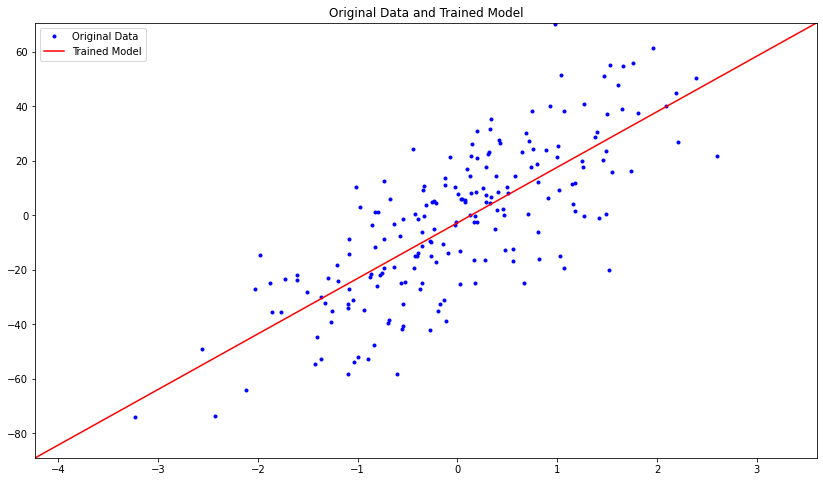

In [29]:
plt.figure(figsize=(14, 8))
plt.title('Original Data and Trained Model')

# For plotting our model:
x_plot = [np.min(X) - 1, np.max(X) + 1]
y_plot = w_hat * x_plot + b_hat

plt.axis([x_plot[0], x_plot[1], y_plot[0], y_plot[1]])
plt.plot(X, y, 'b.', label='Original Data')
plt.plot(x_plot, y_plot, 'r-', label='Trained Model')
plt.legend()
plt.show()

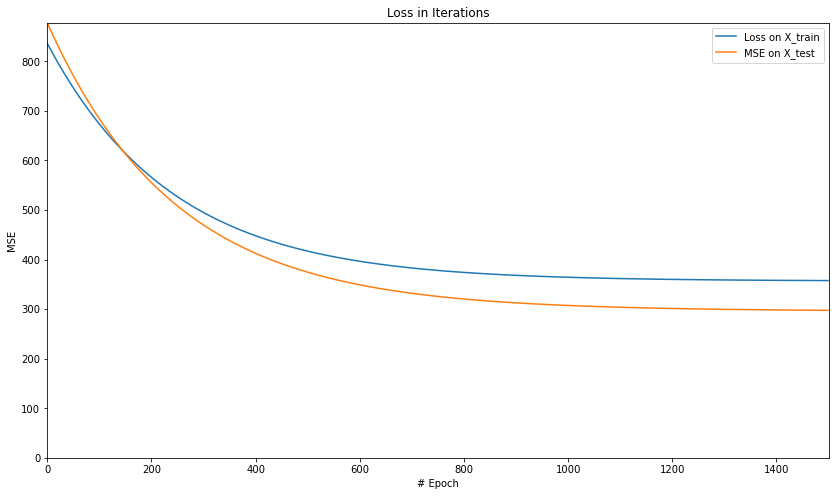

In [30]:
# Plot loss (train set) and MSE (test set)
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max(loss_epochs)])
plt.plot(loss_epochs, label='Loss on X_train')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('MSE')

plt.axis([0, num_epochs, 0, np.max(mse_epochs)])
plt.plot(mse_epochs, label='MSE on X_test')
plt.xlabel('# Epoch')
plt.ylabel('MSE')
plt.legend()

plt.show()

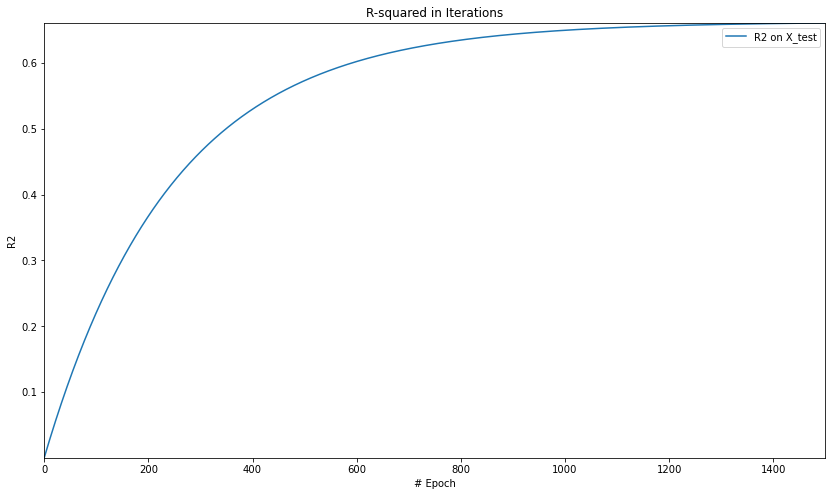

In [31]:
# Plot R^2

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

In [38]:
# Make a prediction on new data:
pred = w_hat * np.asarray([-2.0]) + b_hat
print("pred for x = -2:", pred)

pred for x = -2: [-43.50192285]


# Boston Dataset

In [40]:
boston = sklearn.datasets.load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [41]:
[x for x in dir(boston) if "_" not in x]

['DESCR', 'data', 'filename', 'target']

In [43]:
X = boston.data.astype(np.float32)
y = boston.target.astype(np.float32)

print("X.shape:", X.shape)
print("y.shape:", y.shape)
print("-------------------")
print("X[0]:", X[0])
print("y[0]:", y[0])

X.shape: (506, 13)
y.shape: (506,)
-------------------
X[0]: [6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00]
y[0]: 24.0


In [44]:
if (y.ndim == 1):
    y = y.reshape(-1,1)

print("y.shape:", y.shape)

y.shape: (506, 1)


In [45]:
# Scaling:
X = sklearn.preprocessing.StandardScaler().fit_transform(X)
print("X[0]:", X[0])

X[0]: [-0.41978195  0.28482985 -1.2879095  -0.27259856 -0.14421755  0.4136716
 -0.12001352  0.14021367 -0.98284286 -0.6666082  -1.4590002   0.4410519
 -1.0755622 ]


In [47]:
# Train-test split:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, 
    y, 
    test_size=.4, 
    random_state=123
)

print(X_train.shape)
print(y_test.shape)

(303, 13)
(203, 1)


# Simple Multi Regression

In [48]:
# Get feature size:
num_output_features = y_train.shape[1]
num_input_features = X_train.shape[1]

In [49]:
# Define placeholders
x_tensor = tf.placeholder(
    dtype=tf.float32, 
    shape=[None, num_input_features], 
    name='x'
)
y_tensor = tf.placeholder(
    dtype=tf.float32, 
    shape=[None, num_output_features], 
    name='y'
)

In [50]:
# Note that we initialise w and b as zeros, BTW.
w = tf.Variable(
    tf.zeros([num_input_features, num_output_features]), 
    dtype=tf.float32, 
    name='w'
)
b = tf.Variable(
    tf.zeros([num_output_features]), 
    dtype=tf.float32, 
    name='b'
)

In [51]:
model = tf.matmul(x_tensor, w) + b

In [52]:
loss = tf.reduce_mean(tf.square(model - y_tensor))

In [53]:
mse = tf.reduce_mean(tf.square(model - y_tensor))

y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(model - y_tensor))
rs = 1 - tf.div(unexplained_error, total_error)

In [54]:
# Optimiser:
learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [55]:
num_epochs = 1500

loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0

In [56]:
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        # Training:
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict)
        loss_epochs[epoch] = loss_val
        
        # Evaluation:
        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

In [58]:
print(f"For test data : MSE = {mse_score:.8f}, R2 = {rs_score:.8f}")

For test data : MSE = 30.48796844, R2 = 0.64168775


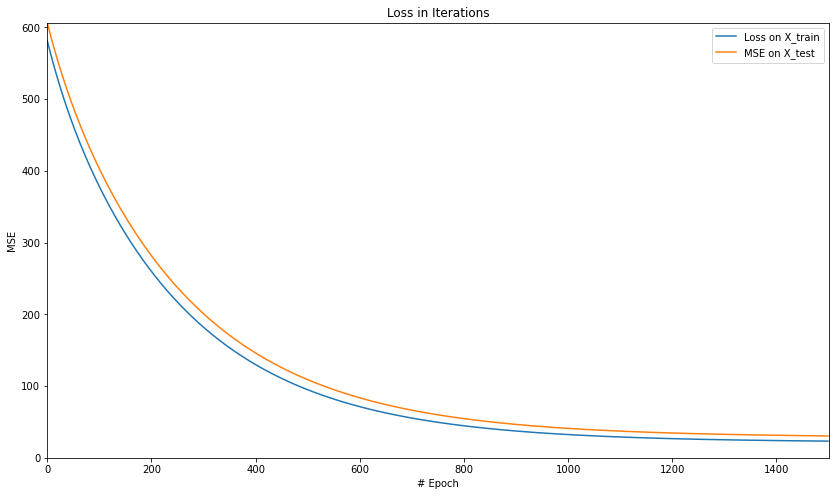

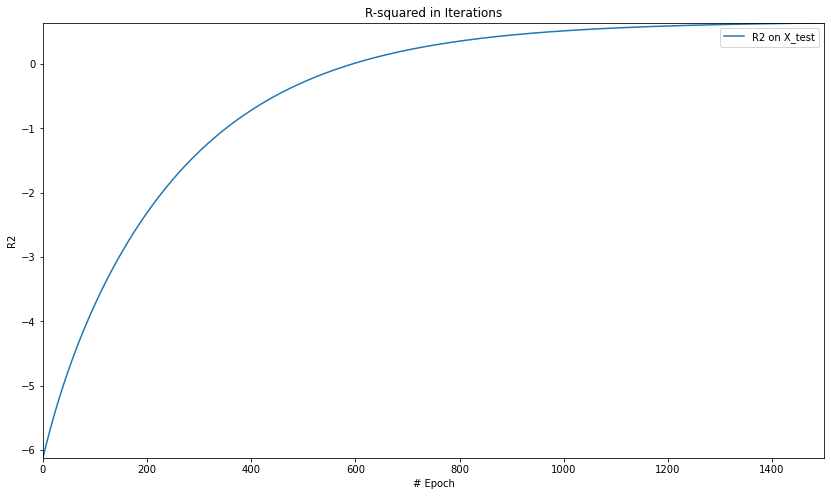

In [59]:
# Plot loss/MSE on train/test over epochs.
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max(loss_epochs)])
plt.plot(loss_epochs, label='Loss on X_train')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('MSE')

plt.axis([0, num_epochs, 0, np.max(mse_epochs)])
plt.plot(mse_epochs, label='MSE on X_test')
plt.xlabel('# Epoch')
plt.ylabel('MSE')
plt.legend()

plt.show()

# Plot R^2 over epochs.
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

# Regularization

## Lasso Regularlization

$Loss + \alpha \frac{1}{n} \sum^{n}_{i=1}|w_i|$

⚠️ Applied to the **weights**.

In [66]:
num_output_features = y_train.shape[1]
num_input_features = X_train.shape[1]

x_tensor = tf.placeholder(
    dtype=tf.float32,                 
    shape=[None, num_input_features], 
    name='x'
)
y_tensor = tf.placeholder(
    dtype=tf.float32,
    shape=[None, num_output_features], 
    name='y'
)

w = tf.Variable(
    tf.zeros([num_input_features, num_output_features]),
    dtype=tf.float32, 
    name='w'
)
b = tf.Variable(
    tf.zeros([num_output_features]),
    dtype=tf.float32, 
    name='b'
)

model = tf.matmul(x_tensor, w) + b

lasso_param = tf.Variable(0.8, dtype=tf.float32)  # Regression parameter \alpha
lasso_loss = tf.reduce_mean(tf.abs(w)) * lasso_param  # (1/n) * \sum_i ( \abs(w_i) ) -- L1 reg.

loss = tf.reduce_mean(tf.square(model - y_tensor)) + lasso_loss  # Add the regularisation term to the loss.

learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

mse = tf.reduce_mean(tf.square(model - y_tensor))

y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [67]:
num_epochs = 1500

loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0

w_final = 0

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val,_ = tfs.run([loss,optimizer], feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score,rs_score = tfs.run([mse,rs], feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score
    
    w_final = tfs.run([w])

print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(mse_score, rs_score))

For test data : MSE = 30.49273300, R2 = 0.64163178 


In [71]:
print(w_final)
# Note many vaules **close to zero**

[array([[-0.55812305],
       [ 0.13013943],
       [-0.12469631],
       [ 0.17903166],
       [-0.4883556 ],
       [ 3.9884288 ],
       [-0.36776042],
       [-1.3324969 ],
       [ 0.39294514],
       [-0.5551546 ],
       [-1.4113836 ],
       [ 0.90252495],
       [-2.9708002 ]], dtype=float32)]


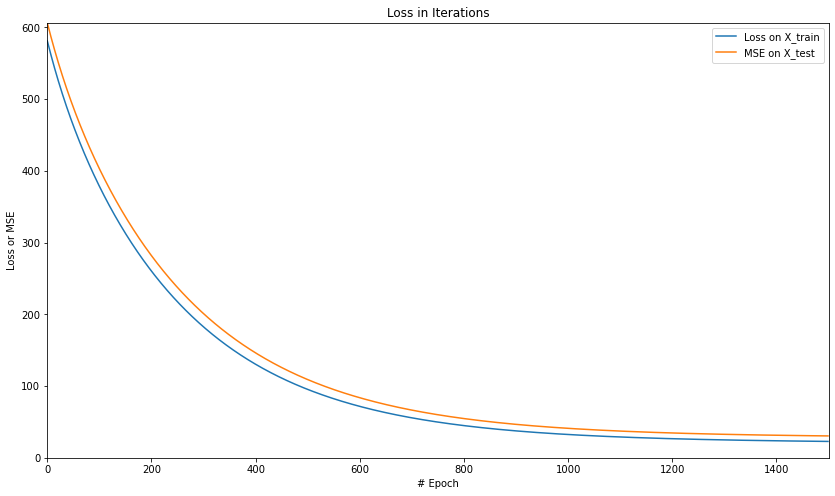

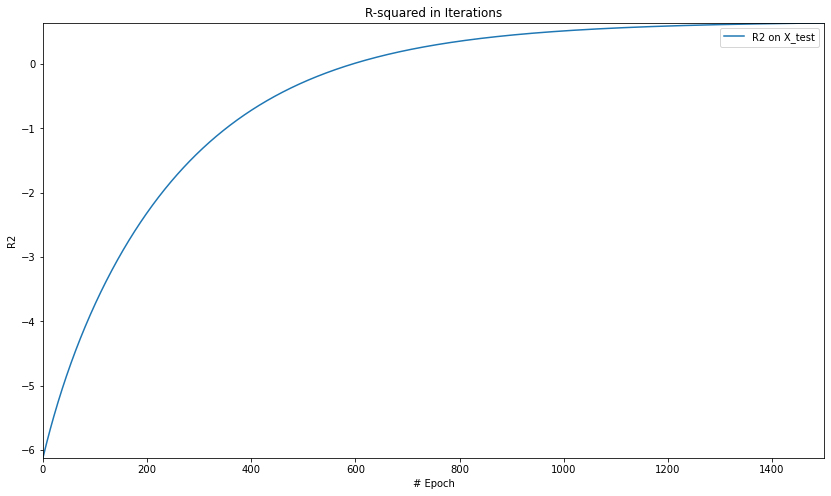

In [62]:
# Same plots...

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max([loss_epochs, mse_epochs])])
plt.plot(loss_epochs, label='Loss on X_train')
plt.plot(mse_epochs, label='MSE on X_test')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('Loss or MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

* **Notice the more "aligned" test and train losses.**

## Ridge Regularization

$Loss + \alpha \frac{1}{n} \sum^{n}_{i=1} w_i^2 $

⚠️ Applied to the **weights**.

In [72]:
num_output_features = y_train.shape[1]
num_input_features = X_train.shape[1]

x_tensor = tf.placeholder(
    dtype=tf.float32,
    shape=[None, num_input_features],
    name='x'
)
y_tensor = tf.placeholder(
    dtype=tf.float32,
    shape=[None, num_output_features], 
    name='y'
)

w = tf.Variable(
    tf.zeros([num_input_features, num_output_features]),
    dtype=tf.float32, 
    name='w'
)
b = tf.Variable(
    tf.zeros([num_output_features]),
    dtype=tf.float32, 
    name='b'
)

model = tf.matmul(x_tensor, w) + b

ridge_param = tf.Variable(0.8, dtype=tf.float32)
ridge_loss = tf.reduce_mean(tf.square(w)) * ridge_param  # Same as before but `square()` not `abs()`

loss = tf.reduce_mean(tf.square(model - y_tensor)) + ridge_loss

learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

mse = tf.reduce_mean(tf.square(model - y_tensor))

y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [73]:
num_epochs = 1500

loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict=feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict=feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(mse_score, rs_score))

For test data : MSE = 30.64427185, R2 = 0.63985085 


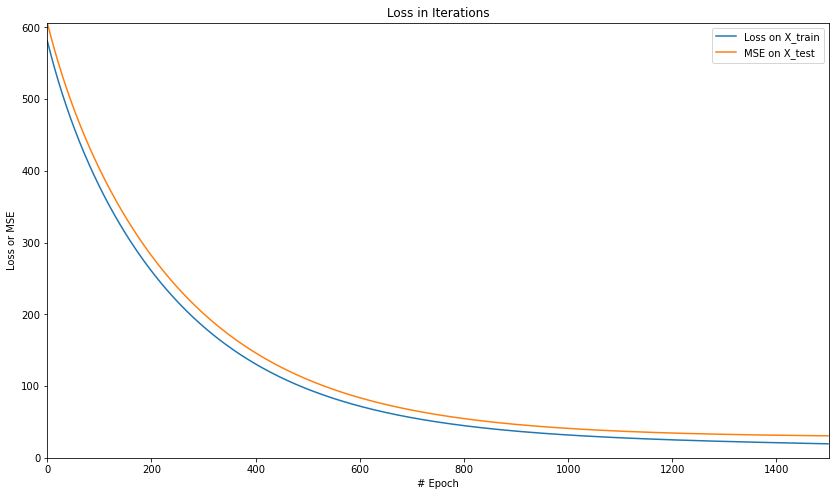

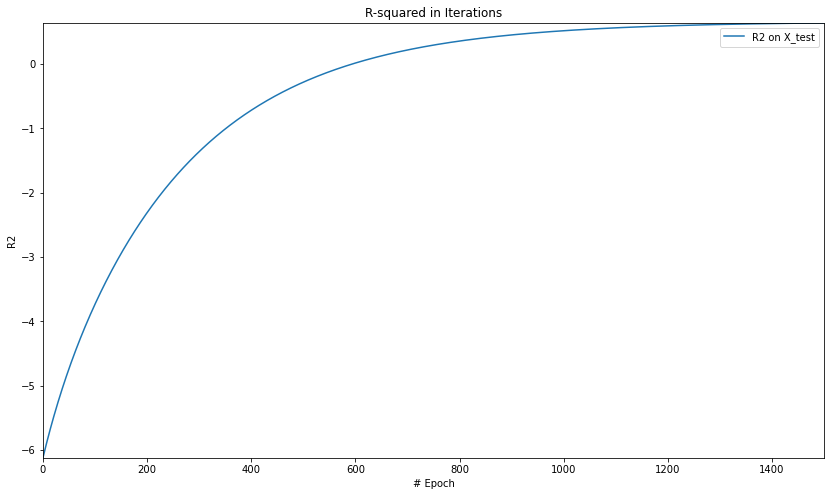

In [74]:
# Same plots...

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max([loss_epochs, mse_epochs])])
plt.plot(loss_epochs, label='Loss on X_train')
plt.plot(mse_epochs, label='MSE on X_test')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('Loss or MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

## ElasticNet Regularization

A combination of BOTH L1 and L2 regressions:

$Loss + \alpha_1 \frac{1}{n} \sum^{n}_{i=1} |w_i| + \alpha_2 \frac{1}{n} \sum^{n}_{i=1} w_i^2 $

In [75]:
num_output_features = y_train.shape[1]
num_input_features = X_train.shape[1]

x_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_input_features], name='x')
y_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_output_features], name='y')

w = tf.Variable(tf.zeros([num_input_features, num_output_features]),
                dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_output_features]),
                dtype=tf.float32, name='b')

model = tf.matmul(x_tensor, w) + b

ridge_param = tf.Variable(0.8, dtype=tf.float32)         # alpha_1
ridge_loss = tf.reduce_mean(tf.square(w)) * ridge_param  # L1 regr. term.
lasso_param = tf.Variable(0.8, dtype=tf.float32)         # alpha_2
lasso_loss = tf.reduce_mean(tf.abs(w)) * lasso_param     # L2 regr. term.

loss = tf.reduce_mean(tf.square(model - y_tensor)) + ridge_loss + lasso_loss  # Add both L1 and L2

learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# mse and R2 functions
mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [76]:
num_epochs = 1500
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict=feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict=feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(mse_score, rs_score))

For test data : MSE = 30.65101814, R2 = 0.63977152 


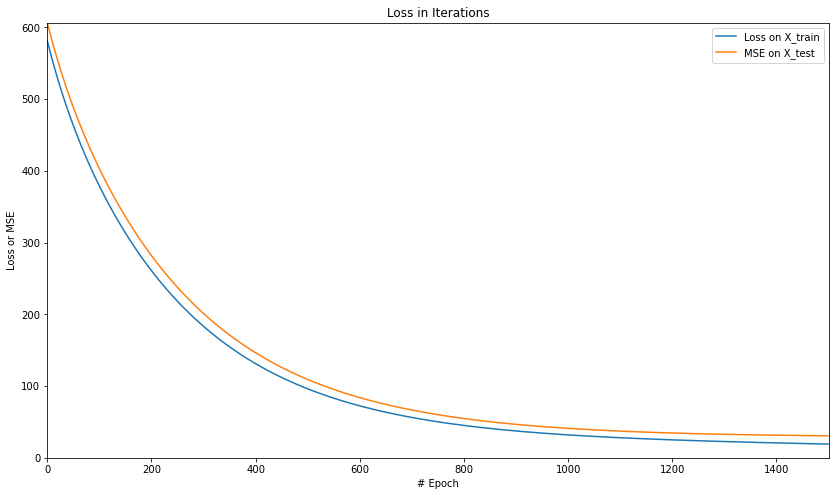

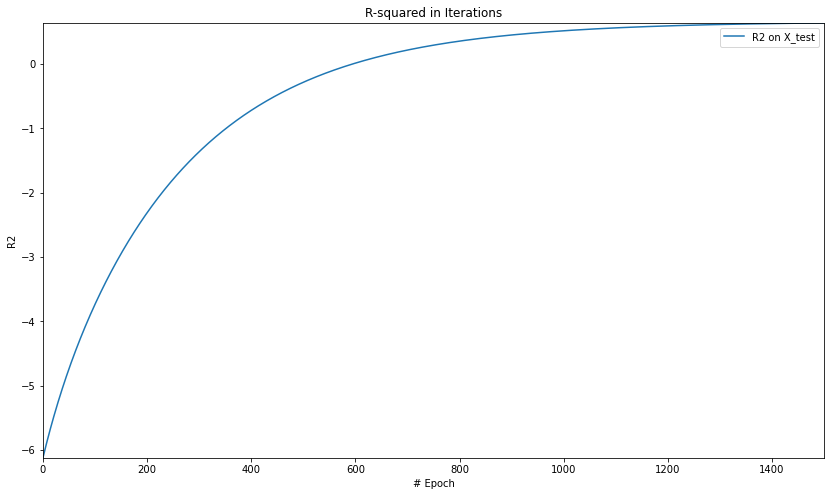

In [77]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max([loss_epochs, mse_epochs])])
plt.plot(loss_epochs, label='Loss on X_train')
plt.plot(mse_epochs, label='MSE on X_test')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('Loss or MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()